In [113]:
import pandas as pd
from datetime import date
from datetime import timedelta
import yfinance as yf
import matplotlib.pyplot as plt

In [114]:
def readTaxLot(fileDir):
	df = pd.read_csv(fileDir, usecols=['UNITS', 'ACQUIRED', 'TICKER', 'UNITCOST'], header=3)
	df = df.dropna()
	df['ACQUIRED'] = pd.to_datetime(df['ACQUIRED'])
	df = df.sort_values(by = 'ACQUIRED')
	return df

savedPrices = []
savedTickers = []

def getPriceAtTime(ticker, dt, interval=7):
	dt = pd.to_datetime(dt)
	if ticker not in savedTickers:
		s = pd.to_datetime(dt) - timedelta(days=3)
		e = pd.to_datetime(dt) + timedelta(days=3)
		df = pd.DataFrame(yf.download(ticker, s, e, progress=False))[['Close']].copy()
		av = round((df['Close'].sum()/len(df['Close']))*100)/100
		savedTickers.append(ticker)
		savedPrices.append(av)
		return av
	else:
		return savedPrices[savedTickers.index(ticker)]

In [115]:
class Folio:
	def __init__(self):
		self.df = pd.DataFrame(columns=['ticker', 'type', 'date', 'quantity', 'price', 'nominal', 'real'])
	def addEvent(self, ticker, type, dt, quantity, price):
		real = price
		real = getPriceAtTime(ticker, date.today())
		self.df.loc[len(self.df.index)] = [ticker, type, pd.to_datetime(dt), quantity, price, int(quantity*price), int(quantity*real)]
	def getNominalValue(self):
		vals = self.df['nominal']
		return vals.sum()
	def getRealValue(self):
		return -1
	def getCurrentBook(self):
		book = {}
		for ticker in list(self.df['ticker'].unique()):
			book[ticker] = 0
			for i, r in self.df[self.df['ticker'] == ticker].iterrows():
				book[ticker] += r['quantity']
		return book
	def getCurrentMarketValue(self):
		curBook = self.getCurrentBook()
		total = 0
		for asset in curBook:
			if asset is not None and asset != 'CASH':
				total += getPriceAtTime(asset, pd.to_datetime(date.today())) * curBook[asset]
			elif asset == 'cash':
				total += curBook[asset]
		return total
			

In [116]:
f = Folio()

firstLot = readTaxLot('./taxLots/TaxLot-d5299c68-8e7b-42d8-9f51-7cddf68aa5ae.csv')
for k in range(len(firstLot)): f.addEvent(firstLot['TICKER'][k], 'gift', firstLot['ACQUIRED'][k], firstLot['UNITS'][k], firstLot['UNITCOST'][k])

tdf = pd.read_csv('TransactionDetail_898efe36-045f-42a8-88ce-82e2e67d1dd3.csv', usecols=[
	'TRANSACTION','TRANSACTIONDESCRIPTION', 'TRANSACTIONTYPE', 'TRADEDATE',
	'SETTLEMENTDATE', 'INCOMECASH', 'PRINCIPALCASH', 'NETCASH', 'CHECK',
	'TAXCODE', 'TAXCODEDESCRIPTION', 'PRINCIPALINVESTMENTCHANGE',
	'INCOMEINVESTMENTCHANGE', 'PRINCIPALSHARESPARCHANGE',
	'INCOMESHARESPARCHANGE', 'UNITPRICE', 'DISBURSEMENTCODE', 
	'TAXCOST', 'BOOKVALUE','GAINLOSS', 'TRANSACTIONTYPE', 'MARKETVALUE',
	'DISBURSEMENTCODEDESCRIPTION', 'HOWACQUIRED', 'TICKER'
], header=3)

for i, r in tdf.iterrows():
	if r['TRANSACTIONTYPE'] is None and r['TRANSACTIONDESCRIPTION'] != 'NET CASH MANAGEMENT':
		f.addEvent('CASH', 'Amo Comp', r['POSTINGDATE'], r['NETCASH'], 1)
	elif r['TRANSACTIONTYPE'] == 'FRR':
		f.addEvent('CASH', 'Gift', r['TRADEDATE'], r['PRINCIPALINVESTMENTCHANGE'], 1)
	elif r['TRANSACTIONTYPE'] == 'DIV': f.addEvent('CASH', 'Dividend', r['TRADEDATE'], r['NETCASH'], 1)
	# elif r['TRANSACTIONTYPE'] == 'DIS' and r['DISBURSEMENTCODE'] == 600: f.addEvent('CASH', 'personal disbursement', r['TRADEDATE'], r['NETCASH'], 1)
	elif (r['TRANSACTIONTYPE'] == 'DIS') and (r['DISBURSEMENTCODE'] == 39 or r['DISBURSEMENTCODE'] == 770 or r['DISBURSEMENTCODE'] == 30): 
		f.addEvent('CASH', 'Tax Prep Fees', r['TRADEDATE'], r['NETCASH'], 1)
	elif r['TRANSACTIONTYPE'] == 'DIS' and r['DISBURSEMENTCODE'] == 310: f.addEvent('CASH', 'misc disbursement', r['TRADEDATE'], r['NETCASH'], 1)
	elif r['TRANSACTIONTYPE'] == 'DIS' and r['DISBURSEMENTCODE'] == 146: f.addEvent('CASH', 'foreign tax withheld', r['TRADEDATE'], r['NETCASH'], 1)
	elif r['TRANSACTIONTYPE'] == 'DIS' and r['DISBURSEMENTCODE'] == 106: f.addEvent('CASH', 'tax paid', r['TRADEDATE'], r['NETCASH'], 1)
	# elif r['TRANSACTIONTYPE'] == 'DIS' and (not ((r['DISBURSEMENTCODE'] == 106) or (r['DISBURSEMENTCODE'] == 146) or (r['DISBURSEMENTCODE'] == 310) or 
	# 	(r['DISBURSEMENTCODE'] == 600) or (r['DISBURSEMENTCODE'] == 39) or (r['DISBURSEMENTCODE'] == 770) or (r['DISBURSEMENTCODE'] == 30))): 
	# 	f.addEvent('CASH', 'other disbursement', r['TRADEDATE'], r['NETCASH'], 1)
	# elif r['TRANSACTIONTYPE'] == 'BUY': 
	# 	f.addEvent(r['TICKER'], 'purchase', r['TRADEDATE'], r['PRINCIPALSHARESPARCHANGE']*r['UNITPRICE'], r['UNITPRICE'])
	# 	f.addEvent('CASH', 'purchase cash', r['TRADEDATE'], r['PRINCIPALSHARESPARCHANGE']*r['UNITPRICE'], r['UNITPRICE'])
	# elif r['TRANSACTIONTYPE'] == 'SEL':
	# 	f.addEvent('CASH', 'income cash', r['TRADEDATE'], (-r['PRINCIPALSHARESPARCHANGE'])*r['UNITPRICE'], 1)
	# 	f.addEvent(r['TICKER'], 'sale', r['TRADEDATE'], (r['PRINCIPALSHARESPARCHANGE'])*r['UNITPRICE'], 1)
	

f.df = f.df.sort_values(by='date')

print(f.df)

cumulatorN = 0
cumulatorR = 0
for i, r in f.df.iterrows():
	cumulatorN += r['nominal']
	f.df.at[i, 'cumulative nominal'] = int(cumulatorN)
	cumulatorR += r['real']
	f.df.at[i, 'cumulative real'] = int(cumulatorR)

    ticker      type       date  quantity  price  nominal   real
11     ADP      gift 1994-04-15     25.00  10.05      251   6172
12     ADP      gift 1994-04-15    105.00  10.05     1055  25922
38     SYK      gift 2000-05-11    114.00  18.46     2104  31881
31    MSFT      gift 2003-05-08    100.00  25.84     2584  32722
39     SYK      gift 2006-05-15     36.00  43.50     1566  10067
..     ...       ...        ...       ...    ...      ...    ...
307   CASH  Dividend 2023-05-31     21.98   1.00       21   1130
305   CASH  Dividend 2023-06-01     53.96   1.00       53   2776
306   CASH  Dividend 2023-06-01     96.09   1.00       96   4943
308   CASH  Dividend 2023-06-08    102.00   1.00      102   5247
309   CASH  Dividend 2023-06-12     24.38   1.00       24   1254

[310 rows x 7 columns]


In [117]:
f.df.to_csv('lwcHistory.csv')

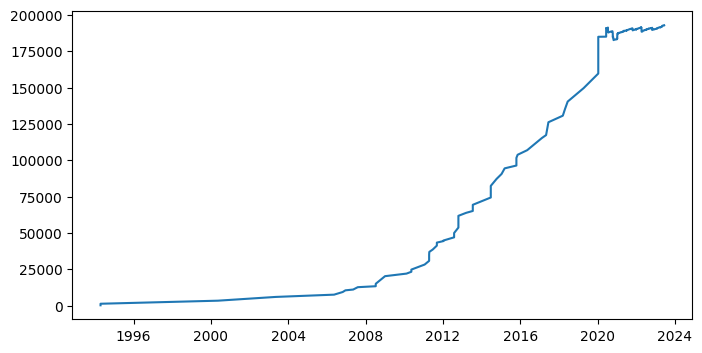

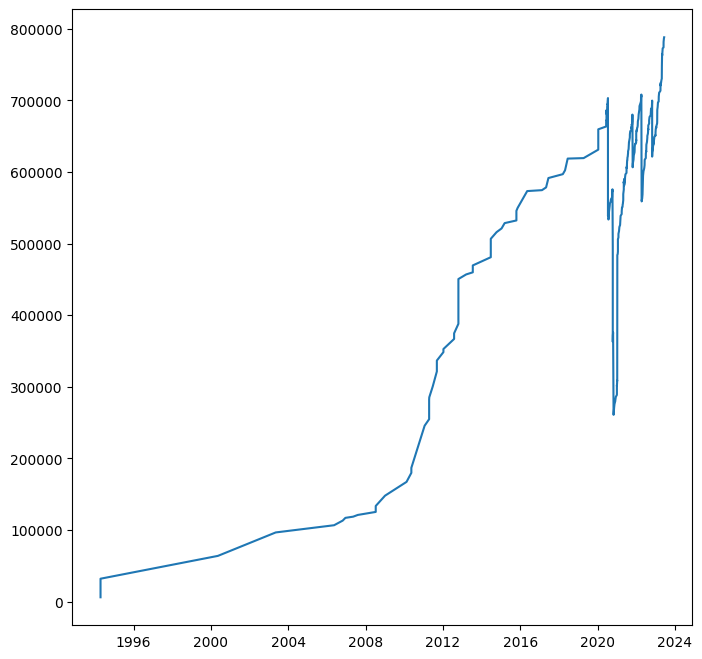

In [118]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f.df['date'], f.df['cumulative nominal'])
fig2, ax2 = plt.subplots(figsize=(8, 8))
ax2.plot(f.df['date'], f.df['cumulative real'])